In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from utils import parse_constraints

Coulpe of example 2D regions

In [146]:
constraints = \
  [ "x <= 2"            "\n"\
    "x >= 0"            "\n"\
    "x + y >= 0"        "\n"\
    "y + 0.5 * x <= 2"  
  , "x + y >= -1"       "\n"\
    "x - y <= 1"        "\n"\
    "x - 2*y >= -1"     
  , "y - x >= -1"       "\n"\
    "x + y >= -1"       "\n"\
    "x >= -1.5"         "\n"\
    "y >= -0.5"           
  ]

variables = ['x','y']

In [147]:
constraints[1]

'x + y >= -1\nx - y <= 1\nx - 2*y >= -1'

In [148]:
A, B = parse_constraints(constraints[2], variables)
A, B = np.array([A[v] for v in variables]), np.array(B)

print(A)
print(B)

[[ 1. -1. -1. -0.]
 [-1. -1. -0. -1.]]
[1.  1.  1.5 0.5]


## Initial sample

I'm getting the starting point by getting all the vertices of the polytope, 
and then finding their average.

In [164]:
import itertools
vertices = []
# For each square submatrix
for ix in itertools.combinations(range(A.shape[1]), A.shape[0]):
    m = A[:,ix]
    # If invertible
    if np.linalg.det(m) == 0: continue
    # Solve and add the vertex
    vertices.append(B[list(ix)].dot(np.linalg.inv(m)))
    
# Apply full constraints
vertices = np.array(vertices)
ix = (vertices.dot(A) <= B[None,:]).all(axis=1)
vertices = vertices[ix].copy()
# Deduplicate
vertices = np.unique(vertices,axis=0)


if vertices.shape[0] < 3:
    raise ValueError("Cannot get initial sample with less than three vertices")

# Starting point
point = vertices.mean(axis=0)

In [165]:
vertices

array([[-1.5,  0.5],
       [-0.5, -0.5],
       [ 0.5, -0.5]])

# Hit-and-run: 

In [166]:
# Random N-dimensional unit vector
def random_dir(ndim):
    x = np.random.uniform(low=-1,high=1,size=ndim)
    return x / np.linalg.norm(x)

In [167]:
direction = random_dir(A.shape[0])

In [168]:
tsamp = (B - point.dot(A)) / direction.dot(A)
tmin, tmax = tsamp[tsamp < 0].max() , tsamp[tsamp > 0].min()
t = np.array([tmin, tmax])
endpoints = point[:,None]  + t[None,:] * direction[:,None]

ValueError: zero-size array to reduction operation maximum which has no identity

### Visualization

In [169]:
XX, YY = np.meshgrid(*[np.linspace(-2,3,201)]*2)
rs = np.array([XX,YY])
rs = np.transpose(rs,axes=(1,2,0)).reshape((-1,2))

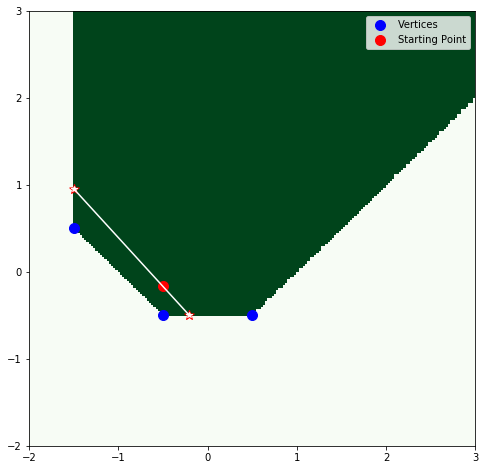

In [170]:
figsize(8,8)
region = (np.dot(A.T,rs.T) <= B[:,None]).all(axis=0).reshape((201,201))
pcolor(XX,YY,region,cmap='Greens')
scatter(*vertices.T, s=100, c='b',label='Vertices')
scatter(*point, s=100, c='r', label='Starting Point')
scatter(*endpoints,marker="*",c="r",s=100)
plot(*endpoints,marker="*",c="w")

legend()

In [176]:
def sample_jump_distance(x, direction):
    numer = (B - x.dot(A))
    denom = direction.dot(A)
    tsamp = numer[denom != 0] / denom[denom != 0]
    
    tmin, tmax = tsamp < 0 , tsamp > 0
    tmin = tsamp[tmin].max() if tmin.any() else None
    tmax = tsamp[tmax].max() if tmax.any() else None
    
    print(tmin, tmax)
    
    if tmin == None and tmax == None:
        return np.random.normal(size=1)
    if tmin == None:
        return tmax - np.random.exponential(size=1)
    if tmax == None:
        return tmin + np.random.exponential(size=1)
    return np.random.uniform(low=tmin, high=tmax)

In [177]:
x = point
sample = []
for _ in range(10000):
    direction = random_dir(A.shape[0])    
    t = sample_jump_distance(x,direction)
    x = x + t * direction
    sample.append(x)
sample = np.array(sample)

-1.8897361705909608 1.281885215523642
-0.126555355417168 5.144781595158876
-1.0707001118867923 5.267341157542595
-0.10683670624339296 7.389232900543915
-1.0584421595821298 21.7252156512984
-2.1890853909959365 40.59024181209752
-30.440794828959337 54.61160568471053
-17.56179448601699 254.47789505724614
-29.665173023296337 None
None 239.0534483740752
-70.29957954171893 1811.5463997116115
-1911.8814375702486 5267.912645250843
-1063.6423313446708 697.9485284428921
-671.0444325569603 5309.112377203639
-416.19527319211426 36377.72790240286
-56.04524710354497 None
-0.5391952263394615 37287.1285834506
-6395.023457340181 81172.00275786828
-8089.142176811477 80600.53332071369
-45341.360667649096 159659.15165137735
None 229763.76556211468
-89101.57798264419 0.4183628442333613
-37214.716851271405 190913.51865159936
-19737.673061288573 325494.9374896702
-239965.6257878446 483056.585153148
-4536.95636613095 1528456.8987422711
-46502.365026522944 9202395.178020611
-451072.09128122014 7554094.21480550

/home/kanishev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in true_divide
  after removing the cwd from sys.path.


OverflowError: Range exceeds valid bounds

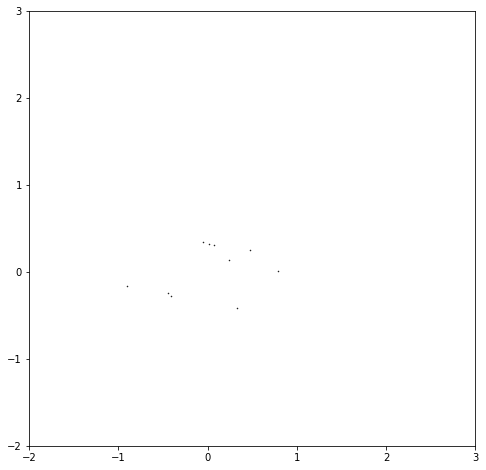

In [175]:
sample = np.array(sample)
xlim(-2,3)
ylim(-2,3)
scatter(*sample.T, marker='.', c='k',s=1)

In [173]:
numer = (B - x.dot(A))
denom = direction.dot(A)
tsamp = numer[denom != 0] / denom[denom != 0]


/home/kanishev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [174]:
x

array([1.04090267e+306, 0.00000000e+000])